<a href="https://colab.research.google.com/github/shaodwing/nmist-fashion/blob/Ajout-learning-rate-schedul/Fashion_NMIST_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Used Joseph Redmon on tiny darknet to produce my work
#Used the work of Adrian Rosebrock for the learning rate schedule

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import backend as K
from keras import utils
from keras.callbacks import Callback, LearningRateScheduler
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, BatchNormalization, Conv2D, GlobalAveragePooling2D, Activation, LeakyReLU, MaxPooling2D
from keras.models import Model
from keras.optimizers import SGD
from sklearn.metrics import classification_report

#Load Data

In [0]:
np.random.seed(2019)
tf.set_random_seed(2019)

(X_train, Y_train ), (X_test, Y_test ) = fashion_mnist.load_data()

#Tiny dark net

In [60]:
batch_size = 256
num_classes = 10 
epochs = 10
img_cols = X_train.shape[1]
img_rows = X_train.shape[2]


if K.image_data_format() == 'channels_first':
  X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols);
  X_test  = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols);
  input_shape = (1, img_rows, img_cols);
else: 
  X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1);
  X_test  = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1);
  input_shape = (img_rows, img_cols, 1);


X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_train /= 255
X_test  /= 255

Y_train = utils.to_categorical(Y_train, num_classes)
Y_test  = utils.to_categorical(Y_test, num_classes)
Y_label = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


#Class used for learning rate scheduling

In [0]:
class LearningRateDecay:
	def plot(self, epochs, title="Learning Rate Schedule"):
		# compute the set of learning rates for each corresponding
		# epoch
		#lrs = [self(i) for i in epochs]
		tempList = []
		epochs = np.arange(1,epochs)
		for i in epochs:
			tempList.append(self(i))
		lrs = np.array(tempList)

		# the learning rate schedule
		plt.style.use("ggplot")
		plt.figure()
		plt.plot(epochs, lrs)
		plt.title(title)
		plt.xlabel("Epoch #")
		plt.ylabel("Learning Rate")


class StepDecay(LearningRateDecay):
	def __init__(self, initAlpha=0.01, factor=0.25, dropEvery=10):
		# store the base initial learning rate, drop factor, and
		# epochs to drop every
		self.initAlpha = initAlpha
		self.factor = factor
		self.dropEvery = dropEvery
	
	def __call__(self, epoch):
		# compute the learning rate for the current epoch
		exp = np.floor((1 + epoch) / self.dropEvery)
		alpha = self.initAlpha * (self.factor ** exp)
		
		# return the learning rate
		return float(alpha)
	

class PolynomialDecay(LearningRateDecay):
	def __init__(self, maxEpochs=100, initAlpha=0.01, power=1.0):
		# store the maximum number of epochs, base learning rate,
		# and power of the polynomial
		# power=1.0 = linear rate decay
		self.maxEpochs = maxEpochs
		self.initAlpha = initAlpha
		self.power = power

	def __call__(self, epoch):
		# compute the new learning rate based on polynomial decay
		decay = (1 - (epoch / float(self.maxEpochs))) ** self.power
		alpha = self.initAlpha * decay

		# return the new learning rate
		return float(alpha)

#Function

In [0]:
def layerConv(output, filters, size, stride, pad, batch_normalization=True, activation='LeakyReLU'):
  output = Conv2D(kernel_size = (size,size), filters = filters, strides=stride, padding=pad)(output)
  if batch_normalization:
    output = BatchNormalization()(output);
  
  #Activation layer
  if activation=='LeakyReLU':
    output = LeakyReLU(alpha = 0.1)(output)
  else:
    output = Activation(activation)(output)
  
  return output


#Tensor model

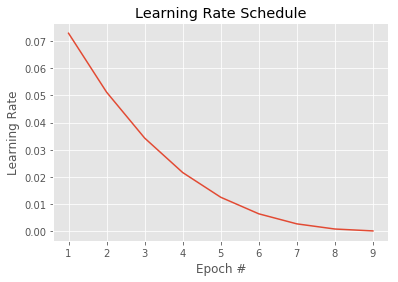

In [54]:
#LAYERS
#First set of convolution (9-12)
input_img = Input(shape=input_shape)
output = layerConv(output=input_img, filters=128, size=3, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output   , filters=32 , size=1, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output   , filters=256, size=3, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output   , filters=32 , size=1, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output   , filters=256, size=3, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')

#Max pooling to get 14x14 feature (13)
output = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same', data_format=None)(output)

#Second set of convolution (14-19)
output = layerConv(output=output, filters=64 , size=1, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output, filters=256, size=3, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU') #512
output = layerConv(output=output, filters=64 , size=1, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output, filters=256, size=3, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU') #512
output = layerConv(output=output, filters=64 , size=1, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU') #128

#Last layer to get an output of 10 class (19+)
output = layerConv(output=output, filters=10, size=1, batch_normalization=False, stride=1, pad="same", activation='linear')
output = GlobalAveragePooling2D()(output)
output = Activation('softmax')(output)

model = Model(input_img, output)
#model.summary()


#Learning Rate schedule
learningRateDecay = PolynomialDecay(maxEpochs=epochs, initAlpha=1e-1, power=3)
learningRateDecay.plot(epochs=epochs)
callbacks = []
callbacks.append(LearningRateScheduler(learningRateDecay))


#Training


In [55]:
opt = SGD(lr=1e-2, momentum=0.9, decay=0.0)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train,
          epochs=epochs,
          batch_size=batch_size,
          shuffle=True, 
          validation_data=(X_test, Y_test),
          callbacks=callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 89s 1ms/step - loss: 0.5319 - acc: 0.8115 - val_loss: 3.1096 - val_acc: 0.4686
Epoch 2/10
60000/60000 [==============================] - 86s 1ms/step - loss: 0.2817 - acc: 0.8982 - val_loss: 0.3603 - val_acc: 0.8730
Epoch 3/10
60000/60000 [==============================] - 86s 1ms/step - loss: 0.2271 - acc: 0.9195 - val_loss: 0.3038 - val_acc: 0.8931
Epoch 4/10
60000/60000 [==============================] - 86s 1ms/step - loss: 0.1963 - acc: 0.9296 - val_loss: 0.2539 - val_acc: 0.9077
Epoch 5/10
60000/60000 [==============================] - 86s 1ms/step - loss: 0.1727 - acc: 0.9382 - val_loss: 0.3039 - val_acc: 0.8888
Epoch 6/10
60000/60000 [==============================] - 86s 1ms/step - loss: 0.1526 - acc: 0.9463 - val_loss: 0.2313 - val_acc: 0.9166
Epoch 7/10
60000/60000 [==============================] - 86s 1ms/step - loss: 0.1376 - acc: 0.9525 - val_loss: 0.2114 - val_acc